In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from random import randint, random

from sklearn.metrics import mean_squared_error
import os

import itertools

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [2]:
path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()

Автокорреляция и частная автокорреляция на дневном (для сравнения) и на месячном интервале.

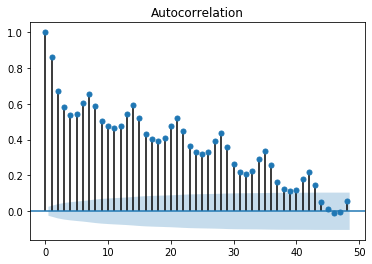

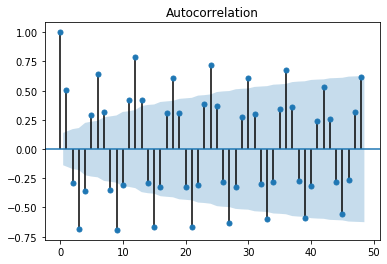

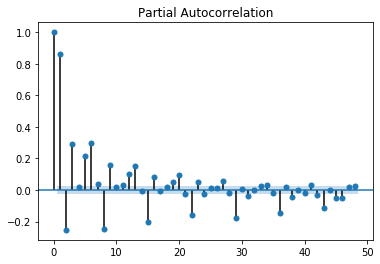

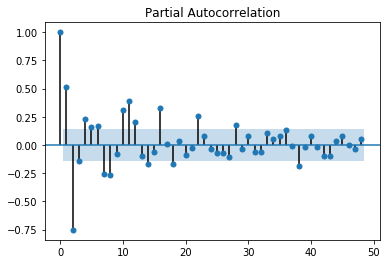

In [4]:
sm.graphics.tsa.plot_acf(data_d['PJME_MW'].values, lags=24*2)
plt.show()

sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=24*2)
plt.show()


sm.graphics.tsa.plot_pacf(data_d['PJME_MW'].values, lags=24*2)
plt.show()

sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=24*2)
plt.show()

На месячном интевале виден период с лагом 12, что соответствует интервалу в 1 год.

Обучаемся на произвольном наборе значений параметров модели для начала.

In [5]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# Задаем комбинации сезонных параметров p, q и q, 
# Для месячных данных сезонный цикл - 12 месяцев.
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,12]

In [6]:
print('SARIMAX: p, d, q =',pdq,'   : ps, ds, qs, S =', seasonal_pdq)

SARIMAX: p, d, q = [1, 2, 2]    : ps, ds, qs, S = [0, 0, 1, 12]


In [7]:
#для построения модели используем все данные, кроме 12-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],
                                order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[1, 2, 2]x[0, 0, 1, 12] - AIC:3204.054461059828


In [8]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 0, 1, 12)   Log Likelihood               -1597.027
Date:                            Mon, 13 Jul 2020   AIC                           3204.054
Time:                                    14:37:09   BIC                           3219.763
Sample:                                         0   HQIC                          3210.428
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Автокорреляция остатков:

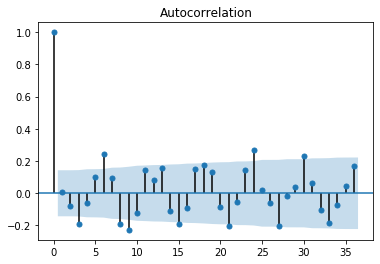

In [9]:
sm.graphics.tsa.plot_acf(results.resid, lags=36)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

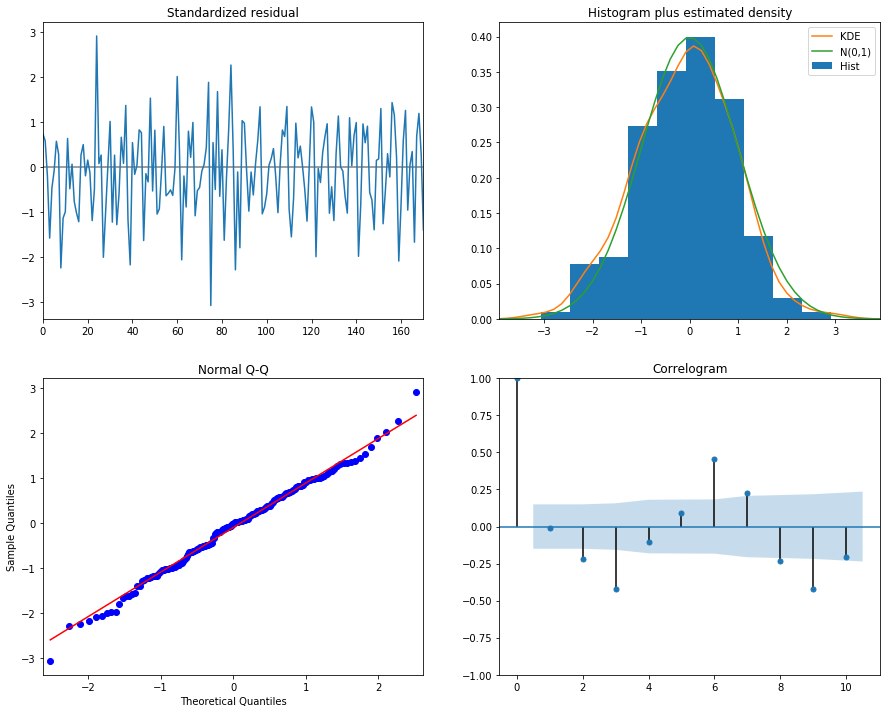

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


Остатки выглядят правильно распределенными, что говорит в пользу высокого качества модели применительно к данному контексту.

Подбираем параметры модели:

In [11]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [12]:
import traceback

r = {}

warnings.filterwarnings("ignore") # отключает предупреждения
tmp = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        tmp += 1
        if tmp > 10:
            break
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[0:-12],
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
            results_ = mod.fit()
            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
        except:
            print(traceback.format_exc())
            pass

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:4416.269672223332
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:4015.3605742791633
SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:3714.465932811062
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:3153.6893700282526
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2927.716207132724
SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:2695.322317184151
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:4259.479361221133
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:4012.9226219369716
SARIMA(0, 0, 1)x(0, 0, 2, 12) - AIC:3675.425501353073
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:3114.0230156115686


Лучшие результаты на недельных данных параметры модели SARIMA(1, 0, 2)x(0, 1, 2, 12) - AIC:2632.781534140128.

In [13]:
#для построения модели используем все данные, кроме 12 последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[0:-12],
                                order=[1,0,2],
                                seasonal_order=[0,1,2,12],
                                
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}', results_opt.aic)


AIC:{} 2632.781534140128


Проведем моделирование прогноза на основе оптимизированной модели SARIMA(1, 0, 2)x(0, 1, 2, 12) - AIC:2632.781534140128, неоптимизированной SARIMAX[1, 2, 2]x[0, 0, 1, 12] - AIC:3204.054461059828, сравним с фактом.

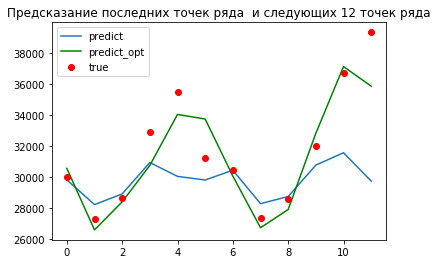

In [14]:
pred_dynamic = results.forecast(12)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(12)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m
         ['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()

plt.show()

In [15]:
from sklearn.metrics import r2_score 
adf_test = sm.tsa.stattools.adfuller(results_opt.resid)


print(adf_test)


(-12.822775001037751, 6.103013722443023e-24, 11, 176, {'1%': -3.4680615871598537, '5%': -2.8781061899535128, '10%': -2.5756015922004134}, 3042.930478228616)


Остатки - стационарный ряд с высокой вероятностью, что характеризует качество найденной модели как хорошее.

### Task_3:

3.	Сделайте вывод о том, как изменилась модель по сравнению с недельной.

##### Ответ:

Сложно сравнивать модели в таких разных контекстах, не уверен что можно в частности использовать критерий Акаике в данном случае. Если смотреть на характер распределения остатков, то для месячного семплирования распределение выглядит ближе к нормальному, вероятно, данная модель описывает и прогнозирует данные лучше чем модель при недельном семплировании.

Возможные причины - шумовая составляющая в процентном соотношении, вероятно, уменьшается в уходе на старшие тайм-фреймы, т.е. шум имеет мат. ожидание в нуле, соотвественно чем выше интервал усреднения, тем ближе фактическое значение среднего по шуму к нулю, чем меньше интервал тем чаще и дальше фактическое значение может уходить от нуля, затрудняя модели прогнозирование.

### Task_4:

4.	Возмите вариант 1 или 2
*	Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
*	Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )

Буду смотреть BRENT - вдруг найду грааль - можно будет сразу и заработать на этом, чё время терять даром.

In [16]:
os.listdir()

['.ipynb_checkpoints',
 '08_estimating_coefficients.png',
 '08_r_squared.png',
 '08_slope_intercept.png',
 'Advertising.csv',
 'AirPassengers.csv',
 'autocorr.png',
 'covid_19_data.csv',
 'Lesson_3_tasks.ipynb',
 'Lesson_3_tasks_draft.ipynb',
 'Linear_TS_review.ipynb',
 'my_BRENT2019.csv',
 'my_PJME_MW.csv',
 'TSS_ESS_RSS.png',
 'Временные ряды 3.html',
 'Временные ряды 3.ipynb',
 'Временные ряды 3.pptx']

In [17]:
df = pd.read_csv('my_BRENT2019.csv', sep=',', parse_dates=['Дата'])
df.head()

,Дата,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
0,2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
1,2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2,2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
3,2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
4,2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 12 columns):
Дата               2667 non-null datetime64[ns]
Значение           2667 non-null float64
year               2667 non-null int64
month              2667 non-null int64
dayofmonth         2667 non-null int64
quarter            2667 non-null int64
dayofyear          2667 non-null int64
weekofyear         2667 non-null int64
dayofweek          2667 non-null int64
is_holiday         2667 non-null int64
is_prev_holiday    2667 non-null int64
is_next_holiday    2667 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(10)
memory usage: 250.1 KB


In [19]:
df.index = df['Дата']
df = df.resample('W').mean()
df = df.fillna(0)
df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000


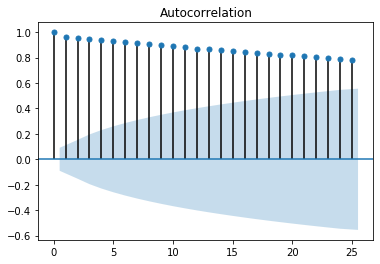

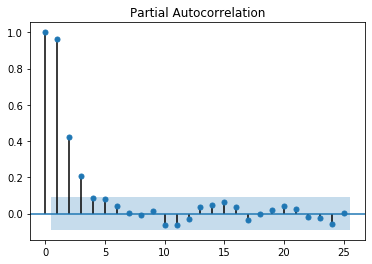

In [20]:
sm.graphics.tsa.plot_acf(df['Значение'], lags=25)
plt.show()

sm.graphics.tsa.plot_pacf(df['Значение'], lags=25)
plt.show()

Строим модель ARIMA:

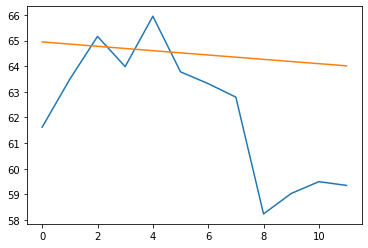

In [48]:
model = ARIMA(df['Значение'].values[:-12], order=(1, 1, 2))
model_fit = model.fit(disp=False)

results = model_fit.forecast(12)

plt.plot(df['Значение'].values[-12:])

plt.plot(results[0])
plt.show()

In [22]:
model_fit.aic

3026.6302465748786

### Task_5:

5.	Оцените результат моделирования

##### Ответ:

Даже по характеру предикта (прямая или около того) видно, что модель не очень хорошо предиктит следующие значения временного ряда. Причина - характер временного ряда а. плохо подходит для данного типа модели, б. временные ряды с подобными характеристики трудно поддаются прогнозированию в принципе.

### Task_6:

6.	Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

##### Ответ:

Лучше модель ARIMA работает с рядами данных с постоянной трендовой состявляющей и выраженной сезонной составляющей. Т.е. модель должна хорошо отрабатывать по всем компонентам, на которые раскладывается ряд, в этом случае и кумулятивный эффект будет хорошим. Если же ряд данных определяется сложным набором факторов, и цикличностью и трендовостью не получается покрыть большую часть влияния факторов - в этом случае модель будет работать не удовлетворительно.